In [12]:
# import utils used in previous notebooks and some more
from llm_challenge.utils.misc import set_openai_api_key, get_completion, read_dict_from_json, write_dict_to_json, read_text


from pathlib import Path
from tqdm import tqdm
import time

In [13]:
# set api
set_openai_api_key()

In [14]:
# let's reproduce the question here:

dset = 'tutorial'
#set the path to the challenge dataset
DATA_DIR = '../data'
qas_dict = read_dict_from_json(f"{DATA_DIR}/qas/qas_{dset}.json")

q_id = "50"
qas_dict[q_id]

{'question': 'What is the recommended range for the value of C1 in the LTC7804 module and why is it chosen in that range?',
 'answer': 'The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. It is chosen in that range to force R1 || R2 to around 2k, reducing error that might have been caused by the SENSE− pin’s ±1μA current.',
 'datasheet': 'parsed/ltc7804.txt'}

In [15]:
# let's consider the pool of datasheets from which answers were taken...
doc_fnames = list(set([DATA_DIR + "/datasheets/" + qa_dict["datasheet"]  for qa_dict in qas_dict.values()]))
doc_fnames

['../data/datasheets/parsed/6416f.txt',
 '../data/datasheets/parsed/ltc7804.txt',
 '../data/datasheets/parsed/DS28E04-100.txt',
 '../data/datasheets/parsed/ADV7611.txt']

In [16]:
# let's pull the datasheet for question 50
doc_idx = doc_fnames.index(str(DATA_DIR + "/datasheets/parsed/ltc7804.txt"))
print(doc_fnames[doc_idx])
text = read_text(doc_fnames[doc_idx])

../data/datasheets/parsed/ltc7804.txt


In [17]:
#     I will give you a peice of text from electrical/electronic module's datashet delimted by ---
#     Your task is to answer question that follows the text based on the provided text.
#     If the text does not contain sufficient information to answer, simple say I do not know.

prompt = """
I will give you a peice of text from electrical/electronic module's datashet delimted by ---
Your task is to give a detailed answer to the question that follows the text based on the provided text.
If the text does not contain sufficient information to answer, just output `IDK`.

Here is the text:
---
{text}
---
Question: {question}
Answer:
"""
# MAXIMUM TOKEN FAILURE!
#get_completion(prompt.format(text=text, question=qas_dict[q_id]["question"]))



In [18]:
# one token is roughly 4 characters (let's be over-conservative)
context_length = 2 * 4000
get_completion(prompt.format(text=text[:context_length], question=qas_dict[q_id]["question"]))

'Based on the provided text, there is no specific information about the recommended range for the value of C1 in the LTC7804 module. Therefore, the answer is "IDK".'

In [19]:
start_idx = text.rfind('C1 value')
get_completion(prompt.format(text=text[start_idx-context_length // 2: start_idx + context_length//2], question=qas_dict[q_id]["question"]))

"The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. This range is chosen to reduce the error caused by the SENSE- pin's ±1μA current. By selecting C1 in this range, the target equivalent resistance R1 || R2 is calculated, which helps in determining the sense resistor values. Additionally, choosing C1 in this range helps in reducing the power loss in R1 and ensures higher efficiency at light loads."

In [20]:
qas_dict[q_id]["answer"]

'The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. It is chosen in that range to force R1 || R2 to around 2k, reducing error that might have been caused by the SENSE− pin’s ±1μA current.'

In [21]:
# besides generating texts, llms give us embeddings ...
# let's see if embeddings can help us with the two-stage search/quest for the right context.
# embeddings ...

### Embeddings 
```
OpenAI’s text embeddings measure the relatedness of text strings. Embeddings are commonly used for:

Search (where results are ranked by relevance to a query string)
Clustering (where text strings are grouped by similarity)
Recommendations (where items with related text strings are recommended)
Anomaly detection (where outliers with little relatedness are identified)
Diversity measurement (where similarity distributions are analyzed)
Classification (where text strings are classified by their most similar label)
An embedding is a vector (list) of floating point numbers. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness.
```
From https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

In [22]:
import openai
import numpy as np
import matplotlib.pyplot as plt

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return np.array(openai.Embedding.create(input = [text], model=model)['data'][0]['embedding'])



In [23]:
texts = [
    "Boston is in the US.",
    "Paris is in France.",
    "Rome is in Italy.",
    "ahead of what is possible.",
    "it will rain tomorrow",
    "it rained a lot yesterday",
    "it is pouring"
]
embeddings = [get_embedding(text) for text in texts]

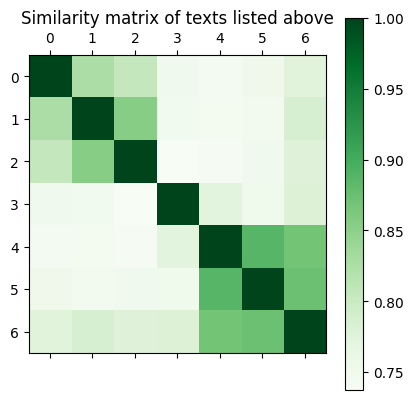

In [24]:
relatedness = [[se.dot(te) for te in embeddings] for se in embeddings]

plt.matshow(relatedness,cmap=plt.cm.Greens)
_ = plt.colorbar()
_ = plt.title("Similarity matrix of texts listed above")

In [25]:
embeddings_fname = f"{DATA_DIR}/qas/embeddings_{dset}.npz"
is_ef_exists = Path(embeddings_fname).exists()
print("Embeddings file does" + " exist." if is_ef_exists else " not exist.")
print("Set `is_generate_ef` to True if you would like to recompute it.")

Embeddings file does exist.
Set `is_generate_ef` to True if you would like to recompute it.


In [26]:
is_generate_ef = False

if is_ef_exists and not is_generate_ef:
    print("loading embeddings from disk")
    # if we have previously created the emebeddings
    embeddings_data = np.load(embeddings_fname)
    embeddings, texts = embeddings_data["embeddings"], embeddings_data["texts"]
elif is_generate_ef:
    # let's read all texts and split them into chunks of permissible context length
    texts = []
    for df in doc_fnames:
        text = read_text(df)
        texts += [text[i:i+context_length] for i in range(0, len(text), context_length)]

    embeddings = []
    for text in texts:
        embeddings.append(get_embedding(text))

    # save
    np.savez(embeddings_fname, embeddings=embeddings, texts=texts)
else:
    print("""It looks like there no embeddings file.
    Set `is_generate_ef` to True to create it.""")

loading embeddings from disk


In [27]:
question = qas_dict[q_id]["question"]

In [28]:
question_embedding = get_embedding(question)

In [29]:
context_embeddings = np.array(embeddings)

In [30]:
for idx, text in enumerate(texts):
    if text.rfind('C1 value')> -1:
        print(idx)

16


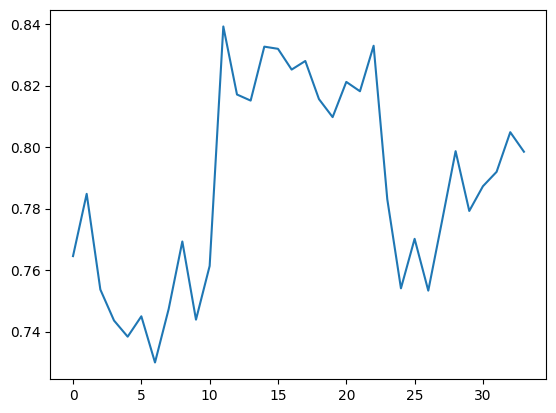

In [31]:
query_embedding = question_embedding
relatedness_score = context_embeddings.dot(query_embedding)
_ = plt.plot(relatedness_score)
top_idxs = np.argsort(-relatedness_score)
selected_by_relatedness_context = texts[top_idxs[5]]

In [32]:
relatedness_score[top_idxs]

array([0.83925435, 0.83298595, 0.83269104, 0.83198635, 0.82802775,
       0.82522633, 0.82122201, 0.81817733, 0.81711798, 0.81561711,
       0.81513555, 0.80975971, 0.80485753, 0.79868318, 0.79850177,
       0.79195493, 0.78727116, 0.78479716, 0.78302251, 0.77922469,
       0.77579904, 0.77015425, 0.7692962 , 0.7645332 , 0.76133758,
       0.75404574, 0.75365762, 0.75329802, 0.74731251, 0.74494939,
       0.74385823, 0.74357613, 0.73831445, 0.72992255])

In [33]:
get_completion(prompt.format(text=texts[top_idxs[0]], question=question))

'Based on the provided text, there is no specific information about the recommended range for the value of C1 in the LTC7804 module. Therefore, the answer is "IDK".'

In [34]:
get_completion(prompt.format(text=texts[top_idxs[5]], question=question))

'The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. This range is chosen to reduce error that might have been caused by the SENSE− pin’s ±1μA current. By selecting C1 in this range, it forces R1 || R2 to be around 2k, which helps to minimize any error caused by the current flowing through the SENSE- pin. This ensures accurate sensing of the voltage drop across the inductor DCR and improves the overall performance and efficiency of the module.'

In [35]:
# something like iterate over the top retrieved texts till I do not know is not returned.
for _ in range(10):
    answer = get_completion(prompt.format(text=texts[top_idxs[_]], question=question))
    if 'IDK' not in answer: 
        break
    else:
        print("Retrieved text does not contain sufficient information.")
print(answer)

Retrieved text does not contain sufficient information.
Retrieved text does not contain sufficient information.
Retrieved text does not contain sufficient information.
Retrieved text does not contain sufficient information.
Retrieved text does not contain sufficient information.
The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. This range is chosen to reduce error that might have been caused by the SENSE− pin’s ±1μA current. By selecting C1 in this range, it forces R1 || R2 to be around 2k, which helps to minimize any error caused by the current flowing through the SENSE- pin. This ensures accurate sensing of the voltage drop across the inductor DCR and improves the overall performance and efficiency of the module.


In [44]:
# Note: one might ask why not just brute-force our dataset till you hit the answer and you certainly can!
# but this takes a hit on number of calls made to LLM.
# https://github.com/hwchase17/langchain/blob/57f370cde97fb3f2c836cbc0dc764be55a571d5a/langchain/callbacks/openai_info.py#L7
MODEL_COST_PER_1K_TOKENS_GPT3P5 = 0.0015

In [45]:
_, num_tokens = get_completion(prompt.format(text=texts[top_idxs[0]], question=question), is_return_total_tokens=True)
print(num_tokens)

2869


In [46]:
num_tokens = 2869
TOP_K = 1000
CONTEXT_LENGTH_IN_K_TOKENS = num_tokens * 1e-3
NUM_QUESTIONS = 1000
# MODEL_COST_PER_1K_TOKENS_GPT3P5 * TOP_K * CONTEXT_LENGTH_IN_K_TOKENS * NUM_QUESTIONS
total_cost_fn = lambda num_tokens: 1e-3 * MODEL_COST_PER_1K_TOKENS_GPT3P5 *  num_tokens 

print(f"Total cost for LLM calls: ${total_cost_fn(num_tokens) * TOP_K * NUM_QUESTIONS}")

Total cost for LLM calls: $4303.5


In [39]:
def get_answer(question, top_k=6):
    question_embedding = get_embedding(question)
    relatedness_score = context_embeddings.dot(question_embedding)
    top_idxs = np.argsort(-relatedness_score)
    total_num_tokens = 0
    for _ in range(top_k):
        selected_by_relatedness_context = texts[top_idxs[_]]
        answer, num_tokens = get_completion(prompt.format(
            text=selected_by_relatedness_context, 
            question=question),is_return_total_tokens=True)
        total_num_tokens += num_tokens
        if 'IDK' in answer:
            continue
        else:
            break
    return answer, total_num_tokens
    
    

In [49]:
# let's try answer all question in the dataset:

answers_with_numpy = {}
max_retries = 5
total_num_tokens = 0

for q_id, qa_dict in tqdm(qas_dict.items()):
    num_tries = 0
    while num_tries < max_retries:
        try:
            time.sleep(0.5)
            answer, num_tokens = get_answer(qa_dict["question"])
            total_num_tokens += num_tokens
            break
        except Exception as e:
            answer = 'can not answer.'
            num_tries +=1

    answers_with_numpy[q_id] = answer

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]


In [50]:
print(f"Finished answering questions using (USD) ${total_cost_fn(total_num_tokens):.5f} ")

Finished answering questions using (USD) $0.04166 


In [59]:
write_dict_to_json(f"gpt3p5-with-top6-embeddings_{dset}.json", answers_with_numpy)

In [ ]:
# this gets us 77.5% accuracy on training set
# 100% on tutorial set.

In [48]:
total_num_tokens

37798